In [234]:
import os
import torch
from torch.utils.data import DataLoader
import fcnn, unet
import metrics
from data.loaders_copy import SteelLoader, AitexDataset, SegmentationMnistDataset
from tqdm.auto import tqdm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import seaborn_image as isns

Specify model and epoch to test

In [235]:
device = torch.device("cuda:0")
res_dir = "training_results_steel_memory/steel-simplefcn-lr-0.001"
load_epoch = 30

# aitex, mnist, steel   
data = "steel"

# simplefcn, unet_v2, unet_paper
model_type = "simplefcn"

Load data and model:

In [236]:
if data == "aitex":
        # increasing batch size risks running out of memory for unets
        loader = DataLoader(AitexDataset(train=False), batch_size= 3)
        dim_in = 1
        dim_out = 2
elif data == "steel":
        # increasing batch size risks running out of memory for unets
        loader = SteelLoader(train = False, batch_size=3) 
        dim_in = 3
        dim_out = 5
elif data == "mnist":
        loader = DataLoader(SegmentationMnistDataset(train = False), batch_size= 10)
        dim_in = 1
        dim_out = 11
else:
        raise ValueError("Unkown Dataset: " + data)

100%|██████████| 1333/1333 [1:36:26<00:00,  4.34s/it]

loaded data


In [237]:
# Select the model type to use
if model_type == "simplefcn":
    network = fcnn.SimpleFCN(dim_in = dim_in, dim_out = dim_out)
elif model_type == "unet_v2":
        network = unet.simple_unet_v2(dim_in, dim_out)
elif model_type == "unet_paper":
        network = unet.simple_unet_paper_version(dim_in, dim_out)
else:
        raise ValueError("Unknown model type: " + model_type)

# use selected device
network.to(device)

# load state
network.load_state_dict(
        torch.load(os.path.join(res_dir, f"epoch{load_epoch}state.torch"),
                map_location=device))
  
network.eval()

SimpleFCN(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (prediction_layer): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
  )
  (upsample_layers): ModuleList(
    (0): Sequential(
      (0): Upsample(scale_factor=2.0, mode=nearest)
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Sequential(
      (0): Ups

Calculate the confusion matrix of predictions:

In [238]:
confusion_matrix = metrics.confusion_matrix([], [], n_classes= dim_out)

# confusion matrix if we agglomerate all detection classes in to one:
# confusion on whether there is a detection or not
null_confusion_matrix = metrics.confusion_matrix([], [], n_classes = 2)

In [239]:
for x, y in tqdm(loader):
    
    pred_probs = network(x.to(device)).to("cpu").detach()

    # update the confusion matrix
    null_class = y.shape[1] - 1 # channel for no detection is last

    pred_labels = np.array(pred_probs.argmax(dim = 1)).flatten()
    true_labels = np.array(y.argmax(dim = 1)).flatten()
    pred_null = (np.array(pred_probs)[:,-1] > 0.5).flatten()

    confusion_matrix += metrics.confusion_matrix(true_labels, pred_labels, y.shape[1])
    null_confusion_matrix += metrics.confusion_matrix(true_labels == null_class, pred_null, 2)

  0%|          | 0/445 [00:00<?, ?it/s]

# Plots

In [240]:
detection_colors = matplotlib.cm.get_cmap("rainbow", dim_out - 1)
c_list = [detection_colors(i / (dim_out - 1)) for i in range(dim_out - 1)] + [(0,0,0)] 
class_colors = matplotlib.colors.LinearSegmentedColormap.from_list("class_colors", c_list)

In [241]:
def plot_confusion_matrix(conf_mat):
    conf_mat = metrics.normalize_confusion(conf_mat)
    metrics.apply_names(conf_mat, mnist = (data == "mnist"))
    plt.figure()
    plot = sns.heatmap(conf_mat, vmin = 0, vmax = 1, annot = True, fmt = ".2f", cmap = "OrRd")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    return plot

In [242]:
def plot_channel(img):
    img = np.array(img)
    if len(img.shape) == 2:
        img = np.reshape(img, (1, *img.shape))
    img = np.transpose(img, (1, 2, 0))
    
    if img.shape[2] == 1:
        return isns.imgplot(img, cmap = "viridis")
    else:
        return isns.imgplot(img)

In [243]:
def plot_predictions(probs: np.ndarray):
    nc = probs.shape[0]
    normed_lab = (np.argmax(probs, axis = 0)) / (nc - 1)
    
    return isns.imgplot(normed_lab, cmap = class_colors, vmin = 0, vmax = 1, cbar = False)

# Metrics

In [244]:
ious = metrics.metric_iou(confusion_matrix)
print(" & ".join([f"{iou:0.2f}" for iou in ious]))

0.02 & 0.00 & 0.37 & 0.08 & 0.92


# Plots For Real This Time

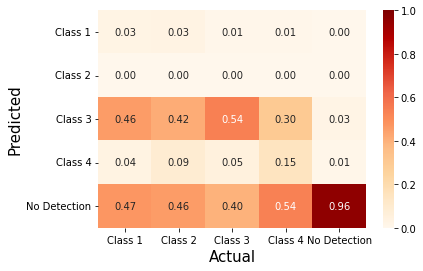

In [245]:
plot_confusion_matrix(confusion_matrix)
plt.savefig(os.path.join(res_dir, "steel_class_confusion.png"))

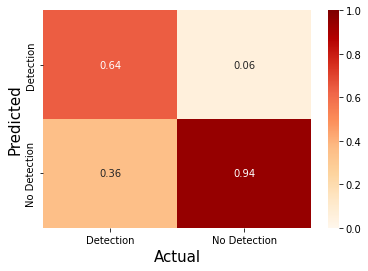

In [246]:
plot_confusion_matrix(null_confusion_matrix)
plt.savefig(os.path.join(res_dir, "steel_null_confusion.png"))

# Get Example Output

In [247]:
# 6 is of interest, so is **7**, 38
data_member_ind = 7

x, y = loader.dataset[data_member_ind]

x = torch.unsqueeze(x, 0).to(device)

member_pred = np.array(network(x)[0].detach().to("cpu"))
x = x.to("cpu")

<AxesSubplot:>

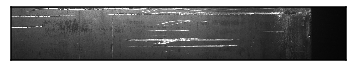

In [248]:
plot_channel(x[0])

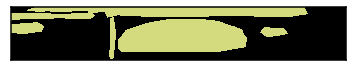

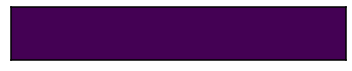

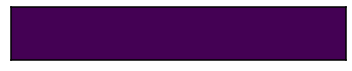

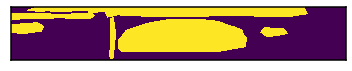

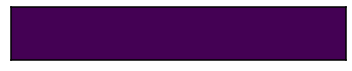

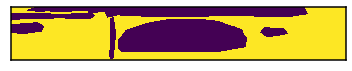

In [249]:
plot_predictions(y)
plt.show()
plt.close()
for i in range(dim_out):
    plot_channel(y[i])

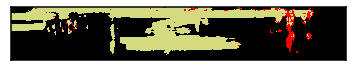

In [250]:
plot_predictions(member_pred)
plt.savefig(os.path.join(res_dir, "example_output.png"))

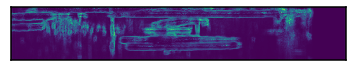

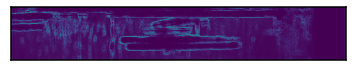

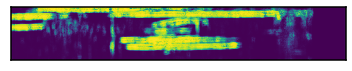

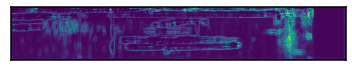

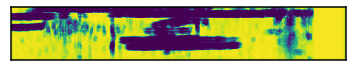

In [251]:
for i in range(dim_out):
    plot_channel(member_pred[i])